# Analysing Characteristics of PageXML Archive

In [1]:
%reload_ext autoreload
%autoreload 2


## Extracting PageXML files from Zip/Tar files

The example zip files contains of smaller zip files, that each have a number of PageXML files. 

In [3]:
import json

from pagexml.analysis.stats import get_doc_stats
from pagexml.helper.file_helper import read_page_archive_files
from pagexml.parser import parse_pagexml_files_from_archive

da_archive_file = '../data/HTR results DA 0114.11 PAGE.zip'
na_archive_file = '../data/HTR results 1.05.06 PAGE.zip'

parse_pagexml_files_from_archive(na_archive_file)


<generator object parse_pagexml_files_from_archive at 0x17b9cfae0>

# Analysing documents based on layout

## Categorising lines by their widths

Lines can vary strongly in how much text they contain, from one or a few characters to a dozen or more words. How much text they contain and how large the characters are, are related to a line's width. 

The distribution of the width of text lines can tell us whether most lines are roughly of similar length, of whether there are different clusters of line widths. Based on these _line width_ clusters, we can cluster scans based on their distribution of line widths, which can help us identify different types of scans. 

We start with an analysis of the distribution of line widths. Scans often have a width of several thousand pixels, with individual characters taking up somewhere between 15 and 150 pixels. 

In [85]:
import seaborn as sns

import pagexml.analysis.layout_stats as layout_stats
from pagexml.parser import parse_pagexml_files_from_archive

sns.set_theme()

scans = parse_pagexml_files_from_archive(na_archive_file)


line_bin_size = 100
line_widths = layout_stats.get_line_widths(scans, line_bin_size)
print(f'Number of lines: {len(line_widths)}')

Number of lines: 1007175


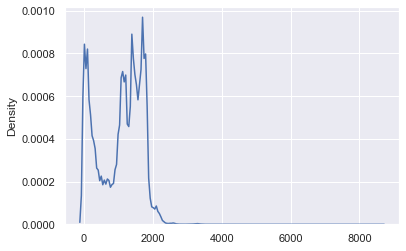

In [86]:
sns.kdeplot(data=line_widths);

We can use the local maxima as centroids of clusters of lines with similar width, and the local minima as boundary points between these clusters. That way, we can categorise the lines of a scan according to these clusters and get summary statistics per scan on the categories of line widths.

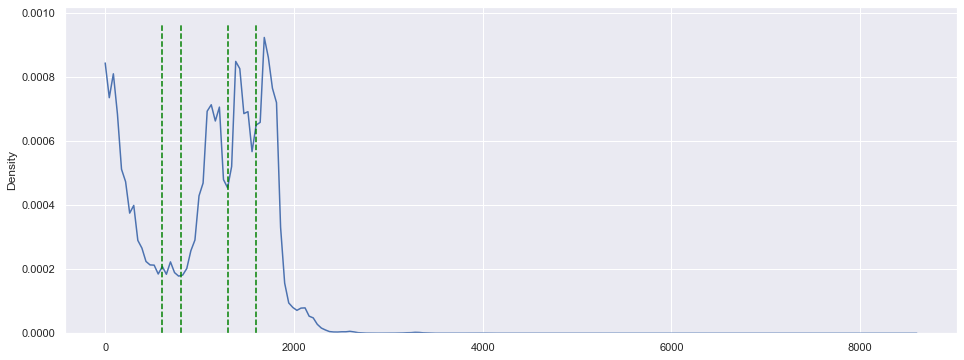

In [87]:
from demo_scripts import plot_line_widths_boundary_points

boundary_points = layout_stats.find_line_width_boundary_points(line_widths, line_bin_size)

plot_line_widths_boundary_points(line_widths, boundary_points)

In [18]:
scans = [scan for scan in parse_pagexml_files_from_archive(na_archive_file)]


# Collecting document statistics

In [88]:
import pagexml.analysis.text_stats as text_stats

scans_stats = []

scans_stats = get_doc_stats(scans, line_width_boundary_points=boundary_points)
  

In [89]:
import pandas as pd

df = pd.DataFrame(scans_stats)

print(df.shape)

df.head(5)

(15857, 26)


,doc_id,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,...,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-
0,NL-HaNA_1.05.06_1_0001.jpg,1,33,165,1,0,0,0,165,1,...,59,17,0,0,0,4,0,2,0,27
1,NL-HaNA_1.05.06_1_0002.jpg,2,59,286,2,0,0,0,286,0,...,134,17,0,0,0,3,0,0,2,54
2,NL-HaNA_1.05.06_1_0003.jpg,3,54,263,2,0,0,0,263,0,...,103,26,0,0,0,2,0,4,1,47
3,NL-HaNA_1.05.06_1_0004.jpg,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NL-HaNA_1.05.06_1_0005.jpg,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Grouping scans by inventory

The archive contains 15,857 scans belonging to 533 inventories. We use the document identifier to add information per scan on the inventory number and the sequence number of the scan in the inventory's list of scans.

Once we have added this inventory and sequence information, we can:

- group scans by inventory and compare inventories on aggregate statistics,
- visualise characteristics of scans per inventory in sequence order.

In [90]:
df['archive_id'] = df.doc_id.apply(lambda x: x.split('_')[1])
df['inv_num'] = df.doc_id.apply(lambda x: x.split('_')[2])
df['scan_num'] = df.doc_id.apply(lambda x: int(x.split('_')[3].replace('.jpg', '')))
df

,doc_id,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,...,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,archive_id,inv_num,scan_num
0,NL-HaNA_1.05.06_1_0001.jpg,1,33,165,1,0,0,0,165,1,...,0,0,4,0,2,0,27,1.05.06,1,1
1,NL-HaNA_1.05.06_1_0002.jpg,2,59,286,2,0,0,0,286,0,...,0,0,3,0,0,2,54,1.05.06,1,2
2,NL-HaNA_1.05.06_1_0003.jpg,3,54,263,2,0,0,0,263,0,...,0,0,2,0,4,1,47,1.05.06,1,3
3,NL-HaNA_1.05.06_1_0004.jpg,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.05.06,1,4
4,NL-HaNA_1.05.06_1_0005.jpg,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.05.06,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,NL-HaNA_1.05.06_99_0036.jpg,15853,46,265,3,0,0,0,265,3,...,0,0,6,0,3,1,35,1.05.06,99,36
15853,NL-HaNA_1.05.06_99_0037.jpg,15854,44,297,3,0,0,0,297,4,...,0,0,4,0,1,0,39,1.05.06,99,37
15854,NL-HaNA_1.05.06_99_0038.jpg,15855,44,290,3,0,0,0,290,4,...,0,0,4,1,4,2,33,1.05.06,99,38
15855,NL-HaNA_1.05.06_99_0039.jpg,15856,44,252,3,0,0,0,252,6,...,0,0,7,3,3,1,30,1.05.06,99,39


The number of scans per inventory is a heavily skewed distribution. Most inventories have only a handful of scans.

<AxesSubplot:>

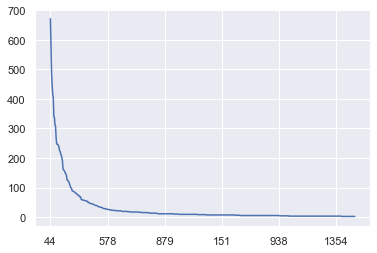

In [114]:
df.inv_num.value_counts().plot()

## Comparing Inventories: numbers of lines and words per scan

We start by looking at descriptive statistics per inventory on the number of lines and words. Big differences in median and mean numbers of words and lines per inventory signal that inventories contain different types of information on their scans. 

### Viewing scans

Because the scans of this archive are also viewable online, we can make visual checks of scans. The scan identifier allows us to construct a viewer URL:

In [103]:
# https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadID=1.05.06&unitID=1&query=1.05.06
def make_iiif_url(row):
    base_url = 'https://www.nationaalarchief.nl/onderzoeken/archief'
    return f"{base_url}/{row['archive_id']}/invnr/{row['inv_num']}/file/{row['doc_id'][:-4]}?eadId={row['archive_id']}&unitID={row['inv_num']}"


def make_clickable(val):
    return f'<a target="_blank" href="{val}">{val}</a>'



df['iiif_url'] = df.apply(lambda row: make_iiif_url(row), axis=1)
df[['doc_id', 'iiif_url']].head(10).style.format({'iiif_url': make_clickable})


,doc_id,iiif_url
0,NL-HaNA_1.05.06_1_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0001?eadId=1.05.06&unitID=1
1,NL-HaNA_1.05.06_1_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0002?eadId=1.05.06&unitID=1
2,NL-HaNA_1.05.06_1_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0003?eadId=1.05.06&unitID=1
3,NL-HaNA_1.05.06_1_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0004?eadId=1.05.06&unitID=1
4,NL-HaNA_1.05.06_1_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1/file/NL-HaNA_1.05.06_1_0005?eadId=1.05.06&unitID=1
5,NL-HaNA_1.05.06_10_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0001?eadId=1.05.06&unitID=10
6,NL-HaNA_1.05.06_10_0002.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0002?eadId=1.05.06&unitID=10
7,NL-HaNA_1.05.06_10_0003.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0003?eadId=1.05.06&unitID=10
8,NL-HaNA_1.05.06_10_0004.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0004?eadId=1.05.06&unitID=10
9,NL-HaNA_1.05.06_10_0005.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/10/file/NL-HaNA_1.05.06_10_0005?eadId=1.05.06&unitID=10


First, we look at inventories with the highest median number of lines:

In [98]:
df.groupby('inv_num').lines.describe().sort_values('50%', ascending=False)

,count,mean,std,min,25%,50%,75%,max
inv_num,,,,,,,,
220,9.0,354.000000,291.980736,0.0,0.00,489.0,604.0,660.0
152,13.0,293.846154,210.249394,0.0,17.00,444.0,457.0,463.0
150,28.0,342.821429,146.928315,0.0,348.25,395.5,419.5,466.0
176,4.0,419.500000,486.183436,0.0,0.00,394.0,813.5,890.0
233,11.0,235.000000,148.666741,0.0,130.50,309.0,334.0,398.0
...,...,...,...,...,...,...,...,...
607,4.0,4.000000,8.000000,0.0,0.00,0.0,4.0,16.0
1235,3.0,17.000000,29.444864,0.0,0.00,0.0,25.5,51.0
42,5.0,21.600000,29.787581,0.0,0.00,0.0,49.0,59.0


There are _huge_ differences. Scans of inventory `220` have a median of 489 lines, while scans of inventory `472` have a median of 17 lines. We can generate clickable viewer URLs to visually inspect the scans of these inventories.

In [93]:
many_line_invs = df.groupby('inv_num').lines.describe().sort_values('50%', ascending=False).head(10).index
(df[df.inv_num.isin(many_line_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
150,NL-HaNA_1.05.06_150_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/150/file/NL-HaNA_1.05.06_150_0001?eadId=1.05.06&unitID=150
151,NL-HaNA_1.05.06_151_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/151/file/NL-HaNA_1.05.06_151_0001?eadId=1.05.06&unitID=151
152,NL-HaNA_1.05.06_152_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/152/file/NL-HaNA_1.05.06_152_0001?eadId=1.05.06&unitID=152
156,NL-HaNA_1.05.06_156_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/156/file/NL-HaNA_1.05.06_156_0001?eadId=1.05.06&unitID=156
176,NL-HaNA_1.05.06_176_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/176/file/NL-HaNA_1.05.06_176_0001?eadId=1.05.06&unitID=176
220,NL-HaNA_1.05.06_220_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/220/file/NL-HaNA_1.05.06_220_0001?eadId=1.05.06&unitID=220
233,NL-HaNA_1.05.06_233_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/233/file/NL-HaNA_1.05.06_233_0001?eadId=1.05.06&unitID=233
236,NL-HaNA_1.05.06_236_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/236/file/NL-HaNA_1.05.06_236_0001?eadId=1.05.06&unitID=236
928,NL-HaNA_1.05.06_928_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/928/file/NL-HaNA_1.05.06_928_0001?eadId=1.05.06&unitID=928


These inventories contain scans with lists and tables. Each cell in the table is represented by a separate line, which is mostly short. **In this archive, a high number of lines per scan signals that the scan represents a table**.


In [161]:
word_cols = [
    'num_words', 'num_number_words', 'num_title_words',
    'num_non_title_words', 'num_stop_words', 'num_punctuation_words',
    'num_oversized_words', 'num_words_length_5', 'num_words_length_10',
    'num_words_length_15', 'num_words_length_20', 'num_words_length_25'
]

line_rel_df = df[word_cols].div(df.lines, axis=0)
line_rel_df['lines'] = df.lines
line_rel_df

,num_words,num_number_words,num_title_words,num_non_title_words,num_stop_words,num_punctuation_words,num_oversized_words,num_words_length_5,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,lines
0,5.000000,0.030303,1.878788,3.121212,NaN,0.030303,0.0,2.696970,1.787879,0.515152,0.0,0.0,33
1,4.847458,0.000000,0.355932,4.491525,NaN,0.000000,0.0,2.288136,2.271186,0.288136,0.0,0.0,59
2,4.870370,0.000000,0.518519,4.351852,NaN,0.000000,0.0,2.481481,1.907407,0.481481,0.0,0.0,54
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15852,5.760870,0.065217,1.521739,4.239130,NaN,0.021739,0.0,3.413043,2.043478,0.304348,0.0,0.0,46
15853,6.750000,0.090909,1.613636,5.136364,NaN,0.022727,0.0,3.863636,2.386364,0.500000,0.0,0.0,44
15854,6.590909,0.090909,1.659091,4.931818,NaN,0.000000,0.0,3.840909,2.113636,0.636364,0.0,0.0,44
15855,5.727273,0.136364,1.863636,3.863636,NaN,0.000000,0.0,3.000000,2.363636,0.363636,0.0,0.0,44


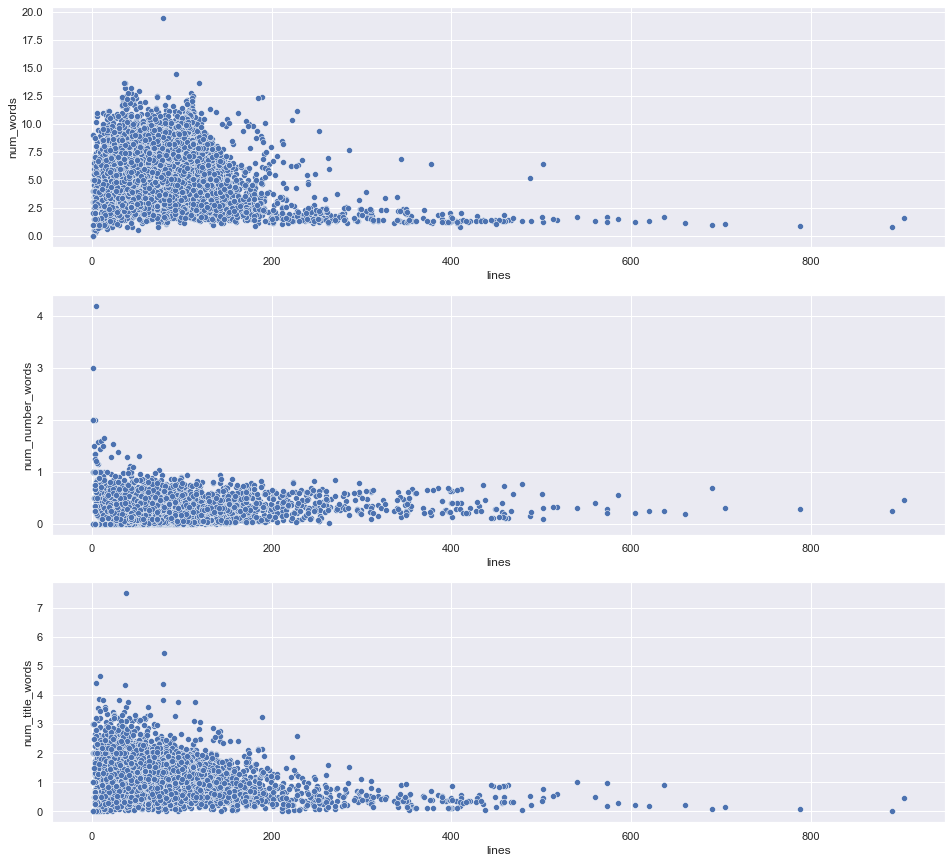

In [162]:
fig, ax = plt.subplots(3, 1)

sns.scatterplot(data=line_rel_df, x='lines', y='num_words', ax=ax[0]);
sns.scatterplot(data=line_rel_df, x='lines', y='num_number_words', ax=ax[1]);
sns.scatterplot(data=line_rel_df, x='lines', y='num_title_words', ax=ax[2]);

fig.set_size_inches(16, 15)

In [145]:
df[df.lines > 500][['words', 'num_number_words', 'num_title_words']]

,words,num_number_words,num_title_words
695,753,164,313
696,750,223,286
1309,978,161,559
1310,1051,153,575
1311,894,162,541
2168,696,467,67
4499,642,154,230
4500,759,160,264
4542,3198,43,383
6999,700,228,57


In [94]:
df.groupby('inv_num').words.describe().sort_values('50%', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
inv_num,,,,,,,,
564A,17.0,1198.588235,702.335929,0.0,605.00,1599.0,1712.0,1793.0
1200,8.0,1312.125000,1424.282921,0.0,0.00,1181.5,2435.0,3198.0
260,8.0,712.375000,455.888125,27.0,337.00,1019.5,1038.5,1043.0
122,10.0,836.200000,637.902257,0.0,243.75,961.5,1425.0,1530.0
1193,15.0,730.800000,340.024621,85.0,520.50,932.0,946.5,1037.0
1220,109.0,849.550459,227.721300,0.0,896.00,926.0,947.0,977.0
24,7.0,648.714286,377.932408,53.0,375.50,905.0,928.5,975.0
1218,148.0,849.918919,264.782044,0.0,667.00,901.5,1040.5,1328.0
714,27.0,784.518519,290.573487,0.0,824.00,888.0,950.0,975.0


In [95]:
many_line_invs = df.groupby('inv_num').words.describe().sort_values('50%', ascending=False).head(10).index

(df[df.inv_num.isin(many_line_invs)]
 .groupby('inv_num')
 .first()[['doc_id', 'iiif_url']]
 .style.format({'iiif_url': make_clickable}))

,doc_id,iiif_url
inv_num,,
1193,NL-HaNA_1.05.06_1193_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1193/file/NL-HaNA_1.05.06_1193_0001?eadId=1.05.06&unitID=1193
1200,NL-HaNA_1.05.06_1200_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1200/file/NL-HaNA_1.05.06_1200_0001?eadId=1.05.06&unitID=1200
1218,NL-HaNA_1.05.06_1218_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1218/file/NL-HaNA_1.05.06_1218_0001?eadId=1.05.06&unitID=1218
122,NL-HaNA_1.05.06_122_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/122/file/NL-HaNA_1.05.06_122_0001?eadId=1.05.06&unitID=122
1220,NL-HaNA_1.05.06_1220_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/1220/file/NL-HaNA_1.05.06_1220_0001?eadId=1.05.06&unitID=1220
24,NL-HaNA_1.05.06_24_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/24/file/NL-HaNA_1.05.06_24_0001?eadId=1.05.06&unitID=24
260,NL-HaNA_1.05.06_260_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/260/file/NL-HaNA_1.05.06_260_0001?eadId=1.05.06&unitID=260
49,NL-HaNA_1.05.06_49_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/49/file/NL-HaNA_1.05.06_49_0001?eadId=1.05.06&unitID=49
564A,NL-HaNA_1.05.06_564A_0001.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/564A/file/NL-HaNA_1.05.06_564A_0001?eadId=1.05.06&unitID=564A


**Inventories with a high median number of words per page are mostly printed material.**

<AxesSubplot:xlabel='words', ylabel='lines'>

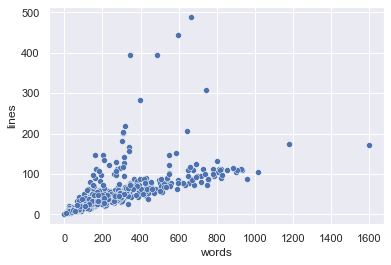

In [110]:
inv_words_lines = df.groupby('inv_num')[['words', 'lines']].describe()

sns.scatterplot(data=inv_words_lines.swaplevel(0,1, axis=1)['50%'], 
                x='words', y='lines')

<AxesSubplot:xlabel='num_number_words', ylabel='lines'>

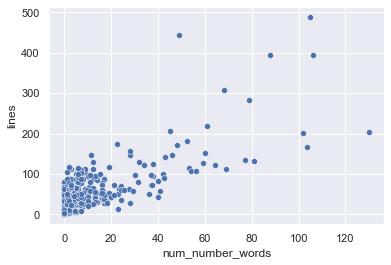

In [116]:
inv_words_lines = df.groupby('inv_num')[['num_number_words', 'lines']].describe()

sns.scatterplot(data=inv_words_lines.swaplevel(0,1, axis=1)['50%'], 
                x='num_number_words', y='lines')

<AxesSubplot:xlabel='doc_num', ylabel='num_words'>

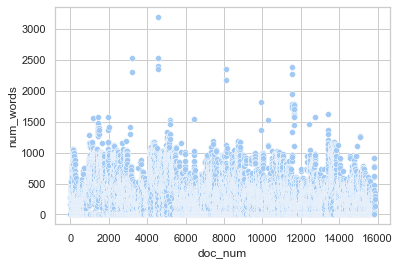

In [23]:
import seaborn as sns

sns.scatterplot(data=df, x='doc_num', y='num_words')

<AxesSubplot:xlabel='doc_num', ylabel='num_title_words'>

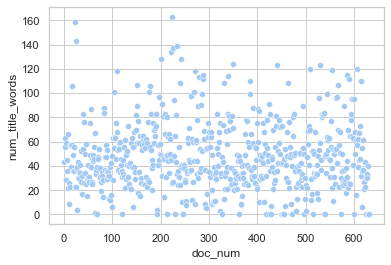

In [163]:
sns.scatterplot(data=df, x='doc_num', y='num_title_words')

## Analysing individual inventories

In [117]:
df.inv_num.value_counts()

44       672
1167     583
45       488
1182     448
812      416
        ... 
525        2
1148       2
1388       2
905        2
1360A      2
Name: inv_num, Length: 533, dtype: int64

In [126]:
inv_44 = df[df.inv_num == '44']

inv_44.describe()

,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,num_title_words,...,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-600,line_width_range_600-800,line_width_range_800-1300,line_width_range_1300-1600,line_width_range_1600-,scan_num
count,672.000000,672.000000,672.000000,672.000000,672.0,672.0,672.0,672.000000,672.000000,672.000000,...,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,9220.500000,59.645833,385.995536,2.389881,0.0,0.0,0.0,385.995536,3.732143,56.163690,...,25.139881,0.950893,0.010417,0.002976,5.747024,0.909226,15.504464,7.008929,30.086310,336.500000
std,194.133974,28.521169,216.081617,1.358229,0.0,0.0,0.0,216.081617,4.815491,35.613214,...,15.822547,1.316738,0.101605,0.054514,6.375366,1.366767,25.416823,17.015551,27.340732,194.133974
min,8885.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9052.750000,45.000000,262.000000,2.000000,0.0,0.0,0.0,262.000000,1.000000,34.000000,...,16.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,168.750000
50%,9220.500000,65.000000,363.000000,2.000000,0.0,0.0,0.0,363.000000,2.000000,49.500000,...,23.000000,1.000000,0.000000,0.000000,4.000000,0.000000,2.500000,1.000000,28.000000,336.500000
75%,9388.250000,75.000000,522.500000,3.000000,0.0,0.0,0.0,522.500000,5.000000,73.000000,...,33.000000,1.000000,0.000000,0.000000,8.000000,1.000000,12.000000,3.000000,54.000000,504.250000
max,9556.000000,141.000000,964.000000,11.000000,0.0,0.0,0.0,964.000000,39.000000,163.000000,...,87.000000,9.000000,1.000000,1.000000,44.000000,13.000000,102.000000,106.000000,81.000000,672.000000


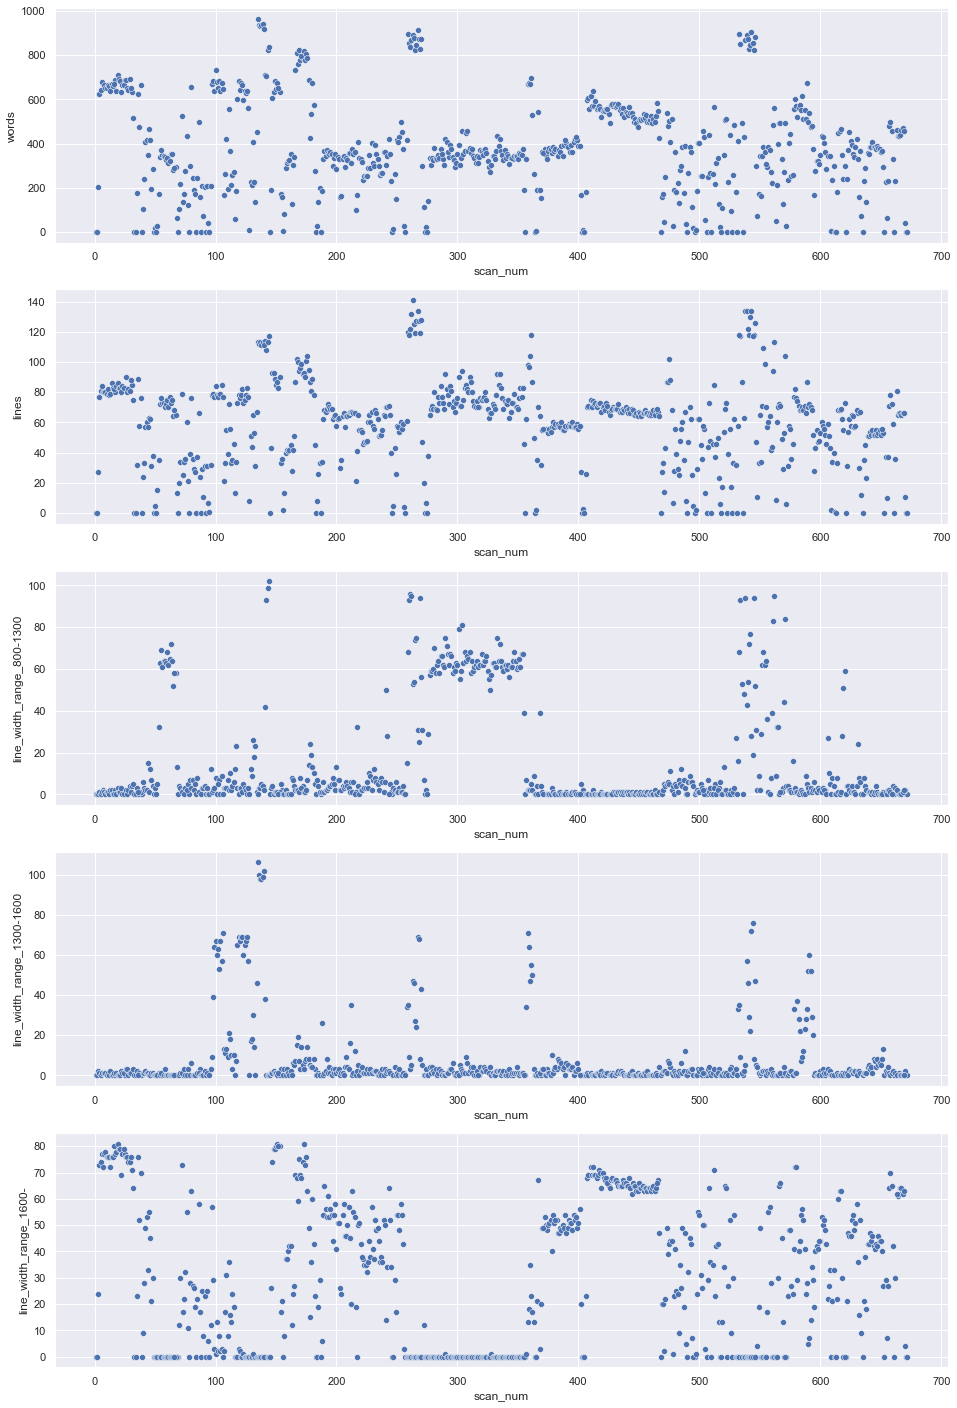

In [129]:
import matplotlib.pyplot as plt

fields = [
    'words', 'lines', 
    #'num_number_words', 
    'line_width_range_800-1300', 
    'line_width_range_1300-1600', 
    'line_width_range_1600-'
]

fig, ax = plt.subplots(len(fields), 1)

for fi, field in enumerate(fields):
    sns.scatterplot(data=inv_44, x='scan_num', y=field, ax=ax[fi])

fig.set_size_inches(16,5*len(fields))

<AxesSubplot:xlabel='line_width_range_800-1300', ylabel='line_width_range_1600-'>

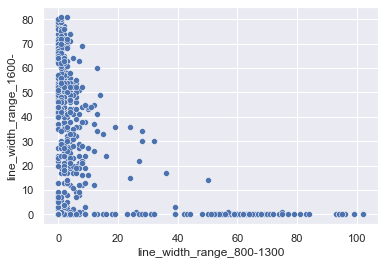

In [130]:
sns.scatterplot(data=inv_44, x='line_width_range_800-1300', y='line_width_range_1600-')

The two categories of line widths are almost mutually exclusive. Scans with at least some lines between 800 and 1300 pixels tend to have _no_ lines wider than 1600 pixels.

In [137]:
inv_44[(inv_44.scan_num > 280) & (inv_44.scan_num < 340)][['doc_id', 'iiif_url']].style.format({'iiif_url': make_clickable})


,doc_id,iiif_url
9164,NL-HaNA_1.05.06_44_0281.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0281?eadId=1.05.06&unitID=44
9165,NL-HaNA_1.05.06_44_0282.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0282?eadId=1.05.06&unitID=44
9166,NL-HaNA_1.05.06_44_0283.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0283?eadId=1.05.06&unitID=44
9167,NL-HaNA_1.05.06_44_0284.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0284?eadId=1.05.06&unitID=44
9168,NL-HaNA_1.05.06_44_0285.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0285?eadId=1.05.06&unitID=44
9169,NL-HaNA_1.05.06_44_0286.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0286?eadId=1.05.06&unitID=44
9170,NL-HaNA_1.05.06_44_0288.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0288?eadId=1.05.06&unitID=44
9171,NL-HaNA_1.05.06_44_0287.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0287?eadId=1.05.06&unitID=44
9172,NL-HaNA_1.05.06_44_0289.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0289?eadId=1.05.06&unitID=44
9173,NL-HaNA_1.05.06_44_0290.jpg,https://www.nationaalarchief.nl/onderzoeken/archief/1.05.06/invnr/44/file/NL-HaNA_1.05.06_44_0290?eadId=1.05.06&unitID=44


In [133]:
word_cols = [
    'num_words', 'num_number_words', 'num_title_words',
    'num_non_title_words', 'num_stop_words', 'num_punctuation_words',
    'num_oversized_words', 'num_words_length_5', 'num_words_length_10',
    'num_words_length_15', 'num_words_length_20', 'num_words_length_25'
]

rel_df = df[word_cols].div(df.num_words, axis=0)
rel_df

,num_number_words,num_title_words,num_non_title_words,num_stop_words,num_punctuation_words,num_oversized_words,num_words_length_5,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25
0,0.006061,0.375758,0.624242,NaN,0.006061,0.0,0.539394,0.357576,0.103030,0.0,0.0
1,0.000000,0.073427,0.926573,NaN,0.000000,0.0,0.472028,0.468531,0.059441,0.0,0.0
2,0.000000,0.106464,0.893536,NaN,0.000000,0.0,0.509506,0.391635,0.098859,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15852,0.011321,0.264151,0.735849,NaN,0.003774,0.0,0.592453,0.354717,0.052830,0.0,0.0
15853,0.013468,0.239057,0.760943,NaN,0.003367,0.0,0.572391,0.353535,0.074074,0.0,0.0
15854,0.013793,0.251724,0.748276,NaN,0.000000,0.0,0.582759,0.320690,0.096552,0.0,0.0
15855,0.023810,0.325397,0.674603,NaN,0.000000,0.0,0.523810,0.412698,0.063492,0.0,0.0


In [165]:
word_cat = 'num_words_length_15'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]

,doc_id,doc_num,num_words,num_words_length_15
64,NL-AsnDA_0114.11_1_0067.jpg,65,7,0.142857
516,NL-AsnDA_0114.11_1_0516.jpg,517,394,0.111675
591,NL-AsnDA_0114.11_1_0592.jpg,592,417,0.107914
478,NL-AsnDA_0114.11_1_0479.jpg,479,28,0.107143
388,NL-AsnDA_0114.11_1_0389.jpg,389,395,0.106329
...,...,...,...,...
572,NL-AsnDA_0114.11_1_0574.jpg,573,0,NaN
599,NL-AsnDA_0114.11_1_0601.jpg,600,0,NaN
624,NL-AsnDA_0114.11_1_0627.jpg,625,0,NaN
628,NL-AsnDA_0114.11_1_0630.jpg,629,0,NaN


In [166]:
word_cat = 'num_number_words'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]


,doc_id,doc_num,num_words,num_number_words
244,NL-AsnDA_0114.11_1_0245.jpg,245,8,0.750000
298,NL-AsnDA_0114.11_1_0300.jpg,299,235,0.178723
73,NL-AsnDA_0114.11_1_0073.jpg,74,524,0.146947
380,NL-AsnDA_0114.11_1_0382.jpg,381,423,0.144208
322,NL-AsnDA_0114.11_1_0324.jpg,323,21,0.142857
...,...,...,...,...
572,NL-AsnDA_0114.11_1_0574.jpg,573,0,NaN
599,NL-AsnDA_0114.11_1_0601.jpg,600,0,NaN
624,NL-AsnDA_0114.11_1_0627.jpg,625,0,NaN
628,NL-AsnDA_0114.11_1_0630.jpg,629,0,NaN


In [167]:
word_cat = 'num_title_words'
rel_df.sort_values(word_cat, ascending=False)[['doc_id', 'doc_num', 'num_words', word_cat]]


,doc_id,doc_num,num_words,num_title_words
469,NL-AsnDA_0114.11_1_0470.jpg,470,22,0.409091
613,NL-AsnDA_0114.11_1_0614.jpg,614,309,0.355987
103,NL-AsnDA_0114.11_1_0104.jpg,104,292,0.345890
423,NL-AsnDA_0114.11_1_0424.jpg,424,268,0.339552
52,NL-AsnDA_0114.11_1_0053.jpg,53,232,0.323276
...,...,...,...,...
572,NL-AsnDA_0114.11_1_0574.jpg,573,0,NaN
599,NL-AsnDA_0114.11_1_0601.jpg,600,0,NaN
624,NL-AsnDA_0114.11_1_0627.jpg,625,0,NaN
628,NL-AsnDA_0114.11_1_0630.jpg,629,0,NaN


<AxesSubplot:xlabel='doc_num', ylabel='num_title_words'>

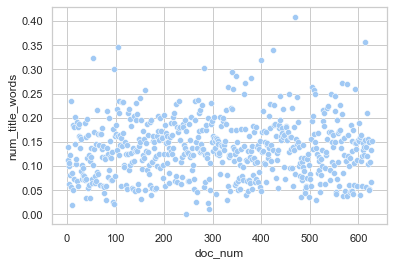

In [164]:
sns.scatterplot(data=rel_df, x='doc_num', y='num_title_words')

In [157]:
title_doc_ids =  set(rel_df[rel_df.num_title_words > 0.3].doc_id)

for scan in scans:
    if scan.id in title_doc_ids:
        print(scan.id)
        for line in scan.get_lines():
            if line.text is None:
                continue
            print('\t', line.text)
        print('\n')
            
            
title_doc_ids

NL-AsnDA_0114.11_1_0053.jpg
	 soo negen
	 5
	 8
	 3
	 1688
	 18
	 7
	 n
	 d
	 2
	 leden den Achtien Mei Achttien
	 honderd Negen en Negentig
	 enhenen voor mj Diederik Anne
	 nane de Trenny notaris ter stindperat
	 Ansen, arrondissement Asen, in tegenwoordigheid
	 der beide natenoemen getuigen.
	 Mijnhuur Aaltien strabling, zonder kroep
	 wonende te soen, weduwe van den den Willem
	 erdons Andiene
	 de Heer Petrus Hermannen Hleema van
	 sael, vandidaat notaris, wonende te Aen
	 en gemaertig van
	 =denthen Oetus Jacobus Andréae, ot alhonder
	 onende te Aen
	 Mejnfouw AAnna Elisabeth Andreae.
	 rorden kwijn wonende te Assen, nedume van
	 den Heer Haarlus Wijdorge
	 = Mijnpouw Aaltje Margaretha Andréae
	 zonden beroep wonende te Eolingels, manue van
	 den Heer Evert Guirink
	 —
	 de den Heer Albertus Hendrikus Kolkers,
	 zonder beroep wonende te Amsterdom, wedeuw
	 naar van Mejuffrouw Helma Annechien
	 ntreal met nie hij in algeheele gemeen
	 shap van goederen was gekuwd.
	 e den Heer Con

{'NL-AsnDA_0114.11_1_0053.jpg',
 'NL-AsnDA_0114.11_1_0097.jpg',
 'NL-AsnDA_0114.11_1_0104.jpg',
 'NL-AsnDA_0114.11_1_0284.jpg',
 'NL-AsnDA_0114.11_1_0400.jpg',
 'NL-AsnDA_0114.11_1_0424.jpg',
 'NL-AsnDA_0114.11_1_0470.jpg',
 'NL-AsnDA_0114.11_1_0614.jpg'}

In [172]:
from pagexml.helper.pagexml_helper import pretty_print_textregion

selected_doc_ids =  set(df[df.num_number_words > 70].doc_id)

for scan in scans:
    if scan.id in selected_doc_ids:
        print(scan.id)
        pretty_print_textregion(scan)
        print('\n')
            
            

selected_doc_ids

NL-AsnDA_0114.11_1_0023.jpg
 door der

 Goederen

 nuard

  em

  hoe

  jem

  idem

  am

  am

  am

  min

  am

  cem

  um

  um

  hul

 wiphar

 weegen

 opzet

 enp

  schuuy

 iim

 een

  dem

 em

  iem

 den

 reen

 ee

 een

 idem

 reen

 een

 dem

 een

 en

 den

 dem

 eem

 ren

 en

 een

 eeen

        die in en maand October nansteende met

        heitnud zal dubel stuivergeld verschuldigd zijn

                                                             schuw
        Navoorlezing van vorenstaande voor

                                                              am
         waarden heeft de verkoop plaats gehad en is ver
                                                             um
        kocht als nolgt

                                                             rm

                                                              cum

     eamen der
                    woon
                                 Koopom in
                                       

 zeven gulden vijftig cent
 twee gulem
 twee gulden
 twee gulden dertig cent
 drie gulden vijf en twintig cent
 twee gulden tien cent
 acht gulden vyf en twintig cent
 negen gulden vijftig cnt
 tien gulden vijftig cent
 een gulden vijftig cent
 twee gulden veertig cent
 twee gulden veertig ent
 elf gulden
 een geleen zestig cent
 twintig gulden
 acht geleen
 even gulden
 een gulden vijf en zevintig cent
 een guleen
 vier gulden vijf en twintig cent
 vier gulden
 vier gulden
 ij gulden
 vijftig cent
 vyftig cent
 twintigeent
 twee guleen
 twee gulden vijftig cent
 dertien gulden
 vier gulden
 vier gulden vijf en twintig cent
 twaalf gulden vijf en twintig cent
 twaalf gulden vyf en zeventig cent
 twee gulden twintig cent
 zeven gulden vertig cent
 veertig gulden
 drie gulden vijftig cent

 28
  1
    50
   50
 20
 „

 5
 54

  2
   —
 1325
  7 50
    —
  2

    —
  2


  5
  d

  95
 1851
  150
  d
  240
 1
  1 60
 de
  8
  3
  173

    25

  7


   50
   70
  2

   50
 1
 4
   e
  4
  

                                                                                  nn
              Navoorlezing van vorenstaande voorwaarden heeft
                                                               dezelvde

                                                                                        vier gulden vig en twintig cent

                                                                                  den
                                                              dacab van veen
              de verkoop plaats gehad en is verkocht, als volgt:

                                                                                        weede gulden vijftig cent

                                                                                  een

                                                             Gereerd Schapfelmeer

                                                                                  Kloosterne vier gulden

                                       

{'NL-AsnDA_0114.11_1_0023.jpg',
 'NL-AsnDA_0114.11_1_0073.jpg',
 'NL-AsnDA_0114.11_1_0229.jpg',
 'NL-AsnDA_0114.11_1_0286.jpg',
 'NL-AsnDA_0114.11_1_0343.jpg',
 'NL-AsnDA_0114.11_1_0439.jpg',
 'NL-AsnDA_0114.11_1_0554.jpg'}

<AxesSubplot:xlabel='doc_num', ylabel='num_number_words'>

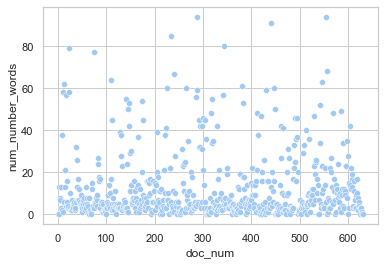

In [162]:
sns.scatterplot(data=df, x='doc_num', y='num_number_words')

<AxesSubplot:xlabel='doc_num', ylabel='lines'>

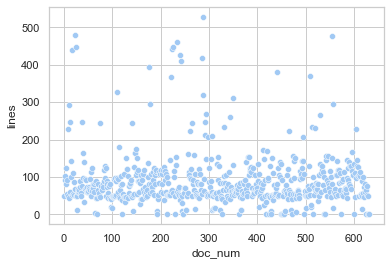

In [173]:
sns.scatterplot(data=df, x='doc_num', y='lines')

In [174]:
df.describe()

,doc_num,lines,words,text_regions,columns,extra,pages,num_words,num_number_words,num_title_words,...,num_words_length_5,num_words_length_10,num_words_length_15,num_words_length_20,num_words_length_25,num_words_length_30,line_width_range_0-1300,line_width_range_1300-1600,line_width_range_1600-2100,line_width_range_2100-
count,630.000000,630.000000,630.000000,630.000000,630.0,630.0,630.0,630.000000,630.000000,630.000000,...,630.000000,630.000000,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,315.500000,90.000000,379.247619,3.942857,0.0,0.0,0.0,379.247619,12.587302,47.455556,...,225.022222,131.755556,20.179365,2.198413,0.08254,0.007937,46.363492,5.585714,34.144444,0.009524
std,182.009615,74.141488,180.191760,3.037116,0.0,0.0,0.0,180.191760,16.089016,28.170451,...,111.474891,63.980004,11.540537,1.721554,0.29760,0.088803,74.301065,9.903740,20.714727,0.112373
min,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.250000,51.000000,279.250000,2.000000,0.0,0.0,0.0,279.250000,3.000000,29.250000,...,160.000000,99.000000,12.000000,1.000000,0.00000,0.000000,13.000000,1.000000,19.000000,0.000000
50%,315.500000,71.000000,366.500000,3.000000,0.0,0.0,0.0,366.500000,6.000000,43.500000,...,216.000000,121.000000,19.000000,2.000000,0.00000,0.000000,20.000000,2.000000,35.000000,0.000000
75%,472.750000,106.000000,502.750000,5.000000,0.0,0.0,0.0,502.750000,15.000000,62.000000,...,300.000000,172.000000,28.000000,3.000000,0.00000,0.000000,46.000000,4.000000,45.000000,0.000000
max,630.000000,528.000000,940.000000,17.000000,0.0,0.0,0.0,940.000000,94.000000,163.000000,...,618.000000,340.000000,59.000000,8.000000,3.00000,1.000000,510.000000,57.000000,86.000000,2.000000


In [177]:
for scan in scans:
    if scan.stats['words'] > 900:
        print(scan.id, scan.stats)
        #pretty_print_textregion(scan)

NL-AsnDA_0114.11_1_0175.jpg {'lines': 393, 'words': 940, 'text_regions': 4, 'columns': 0, 'extra': 0, 'pages': 0}
NL-AsnDA_0114.11_1_0286.jpg {'lines': 528, 'words': 916, 'text_regions': 7, 'columns': 0, 'extra': 0, 'pages': 0}


In [187]:
stop = False
for scan in scans:
    for tr in scan.text_regions:
        if tr.stats['lines'] > 100:
            #print(scan.id)
            #print(scan.coords.box)
            #print(tr.coords.box)
            print(tr.stats['words'], tr.stats['lines'], tr.stats['words'] / tr.stats['lines'])
            #for line in tr.get_lines():
            #    print(line.text)
            #stop = True
    if stop is True:
        break


212 113 1.8761061946902655
195 107 1.8224299065420562
298 137 2.1751824817518246
314 169 1.8579881656804733
423 229 1.8471615720524017
257 104 2.4711538461538463
282 149 1.8926174496644295
276 134 2.0597014925373136
257 148 1.7364864864864864
450 192 2.34375
303 126 2.4047619047619047
315 164 1.920731707317073
266 118 2.2542372881355934
451 173 2.606936416184971
452 184 2.4565217391304346
448 236 1.8983050847457628
297 112 2.6517857142857144
322 141 2.2836879432624113
360 182 1.978021978021978
280 133 2.1052631578947367
336 146 2.3013698630136985
169 123 1.3739837398373984
173 101 1.7128712871287128
233 101 2.3069306930693068
769 205 3.7512195121951217
212 125 1.696
348 151 2.3046357615894038
320 153 2.0915032679738563
423 231 1.8311688311688312
277 155 1.7870967741935484
230 129 1.7829457364341086
327 137 2.386861313868613
735 307 2.3941368078175898
249 125 1.992
318 124 2.564516129032258
286 105 2.723809523809524
298 133 2.2406015037593985
452 101 4.475247524752476
548 161 3.40372670